In [39]:
!pip install torch-geometric torch-scatter torch-sparse torch-cluster -f https://data.pyg.org/whl/torch-2.0.1+cu117.html
!pip install torch-scatter torch-sparse torch-geometric -f https://data.pyg.org/whl/torch-2.4.0+cu123.html

Looking in links: https://data.pyg.org/whl/torch-2.0.1+cu117.html


In [ ]:
import torch
import torch.nn.functional as F
from torch.nn import Linear
import torch.optim as optim
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GATConv, GlobalAttention, global_mean_pool
from torch_geometric.utils import to_networkx

import networkx as nx
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import roc_auc_score, accuracy_score
from tqdm import tqdm

In [41]:
embeddings = torch.load("/kaggle/input/graphgraph/combined_embeddings.pt")

first_sample = embeddings[0]
print("Keys in first sample:", first_sample.keys())

vqa_embeddings = first_sample["vqa_embeddings"]
print("Shape of VQA embeddings:", vqa_embeddings.shape)
print("First few VQA embeddings:")
print(vqa_embeddings[:5])  

/tmp/ipykernel_23/3863509835.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  embeddings = torch.load("/kaggle/input/graphgraph/combined_embeddings.pt")


Keys in first sample: dict_keys(['image', 'image_embedding', 'caption_embedding', 'meme_text_embedding', 'vqa_embeddings', 'label'])
Shape of VQA embeddings: torch.Size([8, 1, 512])
First few VQA embeddings:
tensor([[[ 0.3052, -0.1429,  0.0414,  ..., -0.1996,  0.2695, -0.0638]],

        [[ 0.2078,  0.0972,  0.0502,  ..., -0.7529, -0.1511, -0.1752]],

        [[ 0.0970,  0.0283,  0.1433,  ..., -0.2025,  0.0647, -0.2893]],

        [[ 0.0288,  0.1465, -0.1470,  ..., -0.3450, -0.0241, -0.0483]],

        [[-0.2030,  0.0526,  0.0879,  ..., -0.5054,  0.0399, -0.2854]]])


Making Graph based on cosine similarity

In [42]:
def create_graph(sample, similarity_threshold=0.7):

    image_node = sample["image_embedding"].squeeze().unsqueeze(0)  # (1, 512)
    caption_node = sample["caption_embedding"].squeeze().unsqueeze(0)  # (1, 512)
    text_node = sample["meme_text_embedding"].squeeze().unsqueeze(0)  # (1, 512)

    
    vqa_nodes = sample["vqa_embeddings"].squeeze(1)  # (8, 512)

    node_features = torch.cat([image_node, caption_node, text_node, vqa_nodes], dim=0)  

    similarity_matrix = cosine_similarity(node_features.cpu().detach().numpy())  
    edge_indices = torch.tensor(
        [[i, j] for i in range(similarity_matrix.shape[0]) for j in range(similarity_matrix.shape[1]) if i != j and similarity_matrix[i, j] >= similarity_threshold],
        dtype=torch.long
    ).t()

    label = torch.tensor(sample["label"], dtype=torch.long)

    return Data(x=node_features, edge_index=edge_indices, y=label)

sample = embeddings[0]
graph = create_graph(sample)
print(graph)

Data(x=[11, 512], edge_index=[2, 72], y=0)


In [43]:
graphs = [create_graph(sample) for sample in embeddings]

total_samples = len(graphs)
train_size = int(0.8 * total_samples)
val_size = int(0.1 * total_samples)

train_graphs = graphs[:train_size] 
val_graphs = graphs[train_size:train_size + val_size]  
test_graphs = graphs[train_size + val_size:] 

train_loader = DataLoader(train_graphs, batch_size=32, shuffle=True)
val_loader = DataLoader(val_graphs, batch_size=32)
test_loader = DataLoader(test_graphs, batch_size=32)


VISUALIZE COSINE SIMILARITY BASED GRAPH

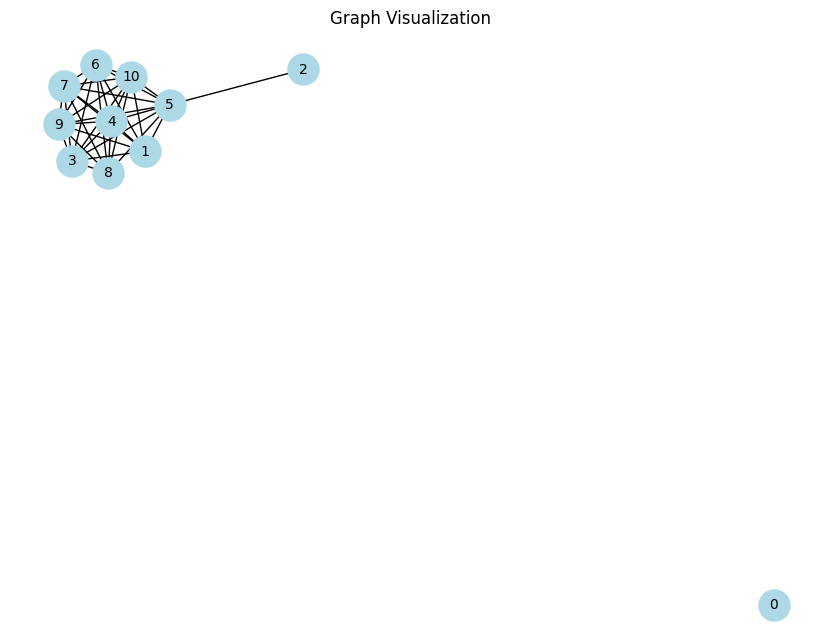

In [9]:

def visualize_graph(graph):
    G = to_networkx(graph, to_undirected=True)
    plt.figure(figsize=(8, 6))
    nx.draw(G, with_labels=True, node_size=500, node_color="lightblue", font_size=10)
    plt.title("Graph Visualization")
    plt.show()

sample_graph = create_graph(embeddings[0])
visualize_graph(sample_graph)

Global Mean Pool

In [44]:

class EnhancedGAT(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_heads=4, dropout=0.5):
        super(EnhancedGAT, self).__init__()
        self.conv1 = GATConv(input_dim, hidden_dim, heads=num_heads, concat=True)
        self.conv2 = GATConv(hidden_dim * num_heads, hidden_dim, heads=num_heads, concat=True)
        self.conv3 = GATConv(hidden_dim * num_heads, hidden_dim, heads=num_heads, concat=False)
        self.fc1 = Linear(hidden_dim, hidden_dim // 2)
        self.fc2 = Linear(hidden_dim // 2, output_dim)
        self.dropout = dropout

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        if x.dim() == 3:
            x = x.squeeze(1)
        x = F.elu(self.conv1(x, edge_index))
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = F.elu(self.conv2(x, edge_index))
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = F.elu(self.conv3(x, edge_index))
        x = global_mean_pool(x, batch)  # Graph-level pooling
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)


AttentionPooling

In [47]:


class EnhancedGATWithAttentionPooling(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_heads=4, dropout=0.5):
        super(EnhancedGATWithAttentionPooling, self).__init__()
        self.conv1 = GATConv(input_dim, hidden_dim, heads=num_heads, concat=True)
        self.conv2 = GATConv(hidden_dim * num_heads, hidden_dim, heads=num_heads, concat=True)
        self.conv3 = GATConv(hidden_dim * num_heads, hidden_dim, heads=num_heads, concat=False)
        
        # Attention Pooling layer
        self.attention_gate = Linear(hidden_dim, 1)  # Gate for attention weights
        self.global_attention = GlobalAttention(self.attention_gate)
        
        self.fc1 = Linear(hidden_dim, hidden_dim // 2)
        self.fc2 = Linear(hidden_dim // 2, output_dim)
        self.dropout = dropout

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        
        if x.dim() == 3:
            x = x.squeeze(1)  # Flatten if 3D tensor
        
        # GAT layers
        x = F.elu(self.conv1(x, edge_index))
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = F.elu(self.conv2(x, edge_index))
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = F.elu(self.conv3(x, edge_index))
        
        # Global Attention Pooling
        x = self.global_attention(x, batch)
        
        # Fully connected layers
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

Global mean pool+cosine similarity result

In [48]:
input_dim = 512 
hidden_dim = 128
output_dim = 2  
num_heads = 4
dropout = 0.5
epochs = 50
learning_rate = 0.001
patience = 5  

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = EnhancedGAT(input_dim, hidden_dim, output_dim, num_heads, dropout).to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)

best_val_loss = float("inf")
best_epoch = 0
patience_counter = 0

def train_model(model, train_loader, val_loader, epochs):
    global best_val_loss, best_epoch, patience_counter
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        y_true, y_pred = [], []
        correct, total = 0, 0 

        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} - Training"):
            batch = batch.to(device)
            optimizer.zero_grad()
            out = model(batch)
            loss = criterion(out, batch.y)
            train_loss += loss.item()

            loss.backward()
            optimizer.step()
            
            y_true.extend(batch.y.cpu().numpy())
            y_pred.extend(torch.softmax(out, dim=1)[:, 1].detach().cpu().numpy())
            pred_labels = torch.argmax(out, dim=1)
            correct += (pred_labels == batch.y).sum().item()
            total += batch.y.size(0)

        train_auc = roc_auc_score(y_true, y_pred)
        train_acc = correct / total
        print(f"Epoch {epoch+1}/{epochs}, Loss: {train_loss/len(train_loader):.4f}, Train AUROC: {train_auc:.4f}, Train Acc: {train_acc:.4f}")

        val_loss, val_auc, val_acc = validate_model(model, val_loader)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_epoch = epoch
            patience_counter = 0
            torch.save(model.state_dict(), "best_model.pth") 
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping triggered at epoch {epoch+1}")
                break

def validate_model(model, val_loader):
    model.eval()
    val_loss = 0
    y_true, y_pred = [], []
    correct, total = 0, 0

    with torch.no_grad():
        for batch in val_loader:
            batch = batch.to(device)
            out = model(batch)
            loss = criterion(out, batch.y)
            val_loss += loss.item()
            y_true.extend(batch.y.cpu().numpy())
            y_pred.extend(torch.softmax(out, dim=1)[:, 1].cpu().numpy())
            pred_labels = torch.argmax(out, dim=1)
            correct += (pred_labels == batch.y).sum().item()
            total += batch.y.size(0)

    val_auc = roc_auc_score(y_true, y_pred)
    val_acc = correct / total
    print(f"Validation Loss: {val_loss/len(val_loader):.4f}, Validation AUROC: {val_auc:.4f}, Validation Acc: {val_acc:.4f}")
    return val_loss / len(val_loader), val_auc, val_acc

def test_model(model, test_loader):
    model.eval()
    y_true, y_pred = [], []
    correct, total = 0, 0

    with torch.no_grad():
        for batch in test_loader:
            batch = batch.to(device)

            out = model(batch)

            y_true.extend(batch.y.cpu().numpy())
            y_pred.extend(torch.softmax(out, dim=1)[:, 1].cpu().numpy())
            pred_labels = torch.argmax(out, dim=1)
            correct += (pred_labels == batch.y).sum().item()
            total += batch.y.size(0)

    test_auc = roc_auc_score(y_true, y_pred)
    test_acc = correct / total
    print(f"Test AUROC: {test_auc:.4f}, Test Accuracy: {test_acc:.4f}")

train_model(model, train_loader, val_loader, epochs)

model.load_state_dict(torch.load("best_model.pth"))  
test_model(model, test_loader)

Epoch 1/50 - Training: 100%|██████████| 89/89 [00:00<00:00, 100.39it/s]


Epoch 1/50, Loss: 0.5323, Train AUROC: 0.7779, Train Acc: 0.7312
Validation Loss: 0.4496, Validation AUROC: 0.8588, Validation Acc: 0.8051


Epoch 2/50 - Training: 100%|██████████| 89/89 [00:00<00:00, 101.57it/s]


Epoch 2/50, Loss: 0.4290, Train AUROC: 0.8707, Train Acc: 0.8095
Validation Loss: 0.4535, Validation AUROC: 0.8659, Validation Acc: 0.7853


Epoch 3/50 - Training: 100%|██████████| 89/89 [00:00<00:00, 105.18it/s]


Epoch 3/50, Loss: 0.4014, Train AUROC: 0.8872, Train Acc: 0.8254
Validation Loss: 0.4161, Validation AUROC: 0.8604, Validation Acc: 0.8164


Epoch 4/50 - Training: 100%|██████████| 89/89 [00:00<00:00, 102.59it/s]


Epoch 4/50, Loss: 0.3745, Train AUROC: 0.9032, Train Acc: 0.8381
Validation Loss: 0.4227, Validation AUROC: 0.8538, Validation Acc: 0.8220


Epoch 5/50 - Training: 100%|██████████| 89/89 [00:00<00:00, 102.41it/s]


Epoch 5/50, Loss: 0.3653, Train AUROC: 0.9068, Train Acc: 0.8395
Validation Loss: 0.4759, Validation AUROC: 0.8424, Validation Acc: 0.7740


Epoch 6/50 - Training: 100%|██████████| 89/89 [00:00<00:00, 102.33it/s]


Epoch 6/50, Loss: 0.3377, Train AUROC: 0.9221, Train Acc: 0.8607
Validation Loss: 0.4721, Validation AUROC: 0.8399, Validation Acc: 0.7797


Epoch 7/50 - Training: 100%|██████████| 89/89 [00:00<00:00, 101.29it/s]


Epoch 7/50, Loss: 0.3089, Train AUROC: 0.9342, Train Acc: 0.8734
Validation Loss: 0.4643, Validation AUROC: 0.8426, Validation Acc: 0.7938


Epoch 8/50 - Training: 100%|██████████| 89/89 [00:00<00:00, 102.03it/s]


Epoch 8/50, Loss: 0.2898, Train AUROC: 0.9430, Train Acc: 0.8780
Validation Loss: 0.5035, Validation AUROC: 0.8337, Validation Acc: 0.7797
Early stopping triggered at epoch 8
Test AUROC: 0.8617, Test Accuracy: 0.8169


/tmp/ipykernel_23/2518461324.py:134: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model.pth"))  # Load the best model


Global attention pooling + cosine similarity

In [49]:
input_dim = 512 
hidden_dim = 128
output_dim = 2  
num_heads = 4
dropout = 0.5
epochs = 50
learning_rate = 0.001
patience = 5 

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = EnhancedGATWithAttentionPooling(input_dim, hidden_dim, output_dim, num_heads, dropout).to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)

best_val_loss = float("inf")
best_epoch = 0
patience_counter = 0

def train_model(model, train_loader, val_loader, epochs):
    global best_val_loss, best_epoch, patience_counter
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        y_true, y_pred = [], []
        correct, total = 0, 0  

        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} - Training"):
            batch = batch.to(device)
            optimizer.zero_grad()

            out = model(batch)
            loss = criterion(out, batch.y)
            train_loss += loss.item()

            loss.backward()
            optimizer.step()

            y_true.extend(batch.y.cpu().numpy())
            y_pred.extend(torch.softmax(out, dim=1)[:, 1].detach().cpu().numpy())
            pred_labels = torch.argmax(out, dim=1)
            correct += (pred_labels == batch.y).sum().item()
            total += batch.y.size(0)

        train_auc = roc_auc_score(y_true, y_pred)
        train_acc = correct / total
        print(f"Epoch {epoch+1}/{epochs}, Loss: {train_loss/len(train_loader):.4f}, Train AUROC: {train_auc:.4f}, Train Acc: {train_acc:.4f}")


        val_loss, val_auc, val_acc = validate_model(model, val_loader)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_epoch = epoch
            patience_counter = 0
            torch.save(model.state_dict(), "best_model.pth")  
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping triggered at epoch {epoch+1}")
                break

def validate_model(model, val_loader):
    model.eval()
    val_loss = 0
    y_true, y_pred = [], []
    correct, total = 0, 0

    with torch.no_grad():
        for batch in val_loader:
            batch = batch.to(device)

            out = model(batch)
            loss = criterion(out, batch.y)
            val_loss += loss.item()

        
            y_true.extend(batch.y.cpu().numpy())
            y_pred.extend(torch.softmax(out, dim=1)[:, 1].cpu().numpy())
            pred_labels = torch.argmax(out, dim=1)
            correct += (pred_labels == batch.y).sum().item()
            total += batch.y.size(0)

    val_auc = roc_auc_score(y_true, y_pred)
    val_acc = correct / total
    print(f"Validation Loss: {val_loss/len(val_loader):.4f}, Validation AUROC: {val_auc:.4f}, Validation Acc: {val_acc:.4f}")
    return val_loss / len(val_loader), val_auc, val_acc

def test_model(model, test_loader):
    model.eval()
    y_true, y_pred = [], []
    correct, total = 0, 0

    with torch.no_grad():
        for batch in test_loader:
            batch = batch.to(device)

            out = model(batch)

            y_true.extend(batch.y.cpu().numpy())
            y_pred.extend(torch.softmax(out, dim=1)[:, 1].cpu().numpy())
            pred_labels = torch.argmax(out, dim=1)
            correct += (pred_labels == batch.y).sum().item()
            total += batch.y.size(0)

    test_auc = roc_auc_score(y_true, y_pred)
    test_acc = correct / total
    print(f"Test AUROC: {test_auc:.4f}, Test Accuracy: {test_acc:.4f}")

train_model(model, train_loader, val_loader, epochs)

model.load_state_dict(torch.load("best_model.pth")) 
test_model(model, test_loader)

/opt/conda/lib/python3.10/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'nn.glob.GlobalAttention' is deprecated, use 'nn.aggr.AttentionalAggregation' instead
  warnings.warn(out)
Epoch 1/50 - Training: 100%|██████████| 89/89 [00:00<00:00, 97.46it/s]


Epoch 1/50, Loss: 0.5089, Train AUROC: 0.7974, Train Acc: 0.7513
Validation Loss: 0.4619, Validation AUROC: 0.8437, Validation Acc: 0.7994


Epoch 2/50 - Training: 100%|██████████| 89/89 [00:00<00:00, 98.97it/s] 


Epoch 2/50, Loss: 0.4367, Train AUROC: 0.8626, Train Acc: 0.8099
Validation Loss: 0.4415, Validation AUROC: 0.8307, Validation Acc: 0.8023


Epoch 3/50 - Training: 100%|██████████| 89/89 [00:00<00:00, 98.86it/s] 


Epoch 3/50, Loss: 0.4296, Train AUROC: 0.8652, Train Acc: 0.8099
Validation Loss: 0.4899, Validation AUROC: 0.8387, Validation Acc: 0.7938


Epoch 4/50 - Training: 100%|██████████| 89/89 [00:00<00:00, 98.23it/s]


Epoch 4/50, Loss: 0.4046, Train AUROC: 0.8852, Train Acc: 0.8286
Validation Loss: 0.4642, Validation AUROC: 0.8218, Validation Acc: 0.8023


Epoch 5/50 - Training: 100%|██████████| 89/89 [00:00<00:00, 96.13it/s]


Epoch 5/50, Loss: 0.3939, Train AUROC: 0.8918, Train Acc: 0.8265
Validation Loss: 0.4500, Validation AUROC: 0.8414, Validation Acc: 0.8051


Epoch 6/50 - Training: 100%|██████████| 89/89 [00:00<00:00, 92.32it/s]


Epoch 6/50, Loss: 0.3717, Train AUROC: 0.9046, Train Acc: 0.8416
Validation Loss: 0.4653, Validation AUROC: 0.8457, Validation Acc: 0.7825


Epoch 7/50 - Training: 100%|██████████| 89/89 [00:00<00:00, 100.11it/s]


Epoch 7/50, Loss: 0.3619, Train AUROC: 0.9087, Train Acc: 0.8420
Validation Loss: 0.4444, Validation AUROC: 0.8469, Validation Acc: 0.8051
Early stopping triggered at epoch 7
Test AUROC: 0.8274, Test Accuracy: 0.8028


/tmp/ipykernel_23/335428314.py:134: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model.pth"))  # Load the best model
